In [ ]:
!pip install kaggle -q
!kaggle datasets download -d hafiznouman786/potato-plant-diseases-data

In [12]:
#! unzip plant-pathology-2021resized-512-x-512.zip
import shutil
shutil.unpack_archive('potato-plant-diseases-data.zip', '.', 'zip')

In [1]:
import warnings

warnings.filterwarnings('ignore')
## Data ##
import numpy as np
import pandas as pd
import os
import sys
import json
import shutil
import pathlib

## Image ##
#import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image


## Tensorflow ##
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, UpSampling2D,\
                                     Dropout, Flatten, Reshape, BatchNormalization, RandomFlip, RandomRotation, Rescaling, Resizing,\
                                       RandomContrast, GaussianNoise, RandomCrop, Input, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler


from tensorflow.keras.applications import  MobileNetV3Large, EfficientNetV2B0,\
                                            ResNet50V2, Xception, InceptionV3, \
                                             MobileNetV3Small, NASNetMobile, InceptionResNetV2


from tensorflow.keras.utils import image_dataset_from_directory

## Visualization ##
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, Javascript, Image, YouTubeVideo

from tensorflow import keras

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import tensorflow.keras.layers as tfl
#print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [2]:
cwd = os.path.abspath('.')
import os
PATH = os.path.join(cwd, 'PotatoPlants')
PATH

'C:\\Users\\tufga\\Downloads\\Projects\\__\\Projects\\Potato\\PotatoPlants'

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
EPOCHS = 50
CHANNELS = 3

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
trainsize = len(dataset) *80//100
print('trainsize', trainsize)

trainds = dataset.take(trainsize)
print(len(trainds))

valds = dataset.take(len(dataset)*10//100)

testds = dataset.take(len(dataset)*10//100)
print(len(testds))

print('Found',tf.data.experimental.cardinality(trainds),'files belonging to 3 classes.' )
print('Found',tf.data.experimental.cardinality((valds)),'files belonging to 3 classes.')
print('Found',tf.data.experimental.cardinality((testds)),'files belonging to 3 classes.')

trainsize 54
54
6
Found tf.Tensor(54, shape=(), dtype=int64) files belonging to 3 classes.
Found tf.Tensor(6, shape=(), dtype=int64) files belonging to 3 classes.
Found tf.Tensor(6, shape=(), dtype=int64) files belonging to 3 classes.


In [11]:
# Iterate over a single batch
for images, labels in trainds.take(1):
    print("Image shape:", images.shape)         #print(img.numpy().shape)
    print("Label shape:", labels.shape)         #print(label.numpy())

class_names = dataset.class_names
class_names

Image shape: (32, 256, 256, 3)
Label shape: (32,)


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[0 1 0 1 1 1 1 0 0 2 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 0]


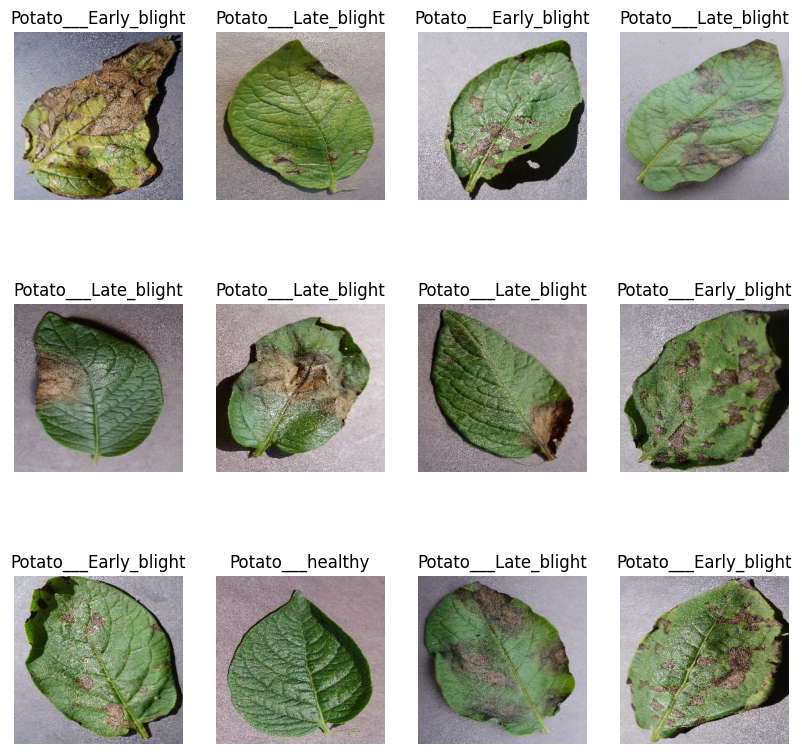

In [10]:
plt.figure(figsize=(10,10))
for img, label in dataset.take(1):
    print(img.numpy().shape)
    print(label.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')

In [5]:
#cache, shuffle, prefetch
AUTOTUNE = tf.data.experimental.AUTOTUNE
trainds = trainds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
valds = valds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
testds = testds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

def create_model(model_name, verbose=False):

    input_tensor = Input(shape=(256, 256, 3))

    if model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    elif model_name == 'inception':
        base_model = InceptionV3(input_tensor=input_tensor, include_top=False, weights='imagenet', input_shape=(256, 256, 3))
    elif model_name == 'nas':
        base_model = NASNetMobile(input_tensor=input_tensor, include_top=False, weights='imagenet', input_shape=(256, 256, 3))

    for layer in base_model.layers:
        layer.trainable = False

    #Data Augmentation
    data_aug = Sequential(
        [RandomFlip('horizontal'),RandomRotation(0.2),
    RandomContrast(0.2), GaussianNoise(0.1), RandomCrop(height=256, width=256)])

    data_re = Sequential(
        [Rescaling(1./255,offset = 0),Resizing(256,256)])  
    

    inputs = Input(shape=(256, 256, 3))
    
    x = data_aug(inputs)
    x = data_re(x)                                          #preprocess_input(x)
    x = base_model(x, training=False)
    
    x = base_model.output                                        # Conv2D(64, MaxPool, Upsampl, Conv2D(64, MaxPool, Flatten,////Dense, Batch, Dropout, Flatten, Dense, Dense(n_classes)
    x = GlobalAveragePooling2D()(x)              
    x = BatchNormalization()(x)
                                                          # Global,Batch,Dense,Flatten,Dropout, //Batch   //,Flatten,Dense,Dense(n)
    x = Dense(32, activation='relu')(x)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    
    
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)

    if verbose:
        model.summary()

    return model

In [9]:
# Xception Modelling
xception_model = create_model(model_name='xception', verbose=False)
xception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
#early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

xception_model.fit(trainds, epochs=9,
         #steps_per_epoch=int(np.ceil(trainds.shape[0]/BATCH_SIZE)),
         validation_data=valds)
         #validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)),
         #callbacks=[rlr_cb, early_cb])
print('Xception Test Data Accuracy: {0}'.format(xception_model.evaluate(testds)[1:][0])) #0.9739999771118164
print(f'Xception Test Data Accuracy: {xception_model.evaluate(testds)[1]:.2f}')

Epoch 1/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.4744 - loss: 1.1494 - val_accuracy: 0.7031 - val_loss: 0.7263
Epoch 2/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.7502 - loss: 0.6155 - val_accuracy: 0.8229 - val_loss: 0.5144
Epoch 3/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.8608 - loss: 0.4283 - val_accuracy: 0.8698 - val_loss: 0.3997
Epoch 4/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.8892 - loss: 0.3373 - val_accuracy: 0.9010 - val_loss: 0.3037
Epoch 5/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9180 - loss: 0.2540 - val_accuracy: 0.9375 - val_loss: 0.2146
Epoch 6/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9356 - loss: 0.2029 - val_accuracy: 0.9479 - val_loss: 0.1737
Epoch 7/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.9595 - loss: 0.1457 - val_accuracy: 0.9635 - val_loss: 0.1503
Epoch 8/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9646 - loss: 0.1199 - val_accuracy: 0.9583 - val_loss:

In [15]:
import joblib

joblib.dump(xception_model, 'xception_97.joblib')

loaded_model = joblib.load('xception_97.joblib')

In [43]:
import joblib
import skl2onnx
from onnx import TensorProto, numpy_helper
from onnx.helper import make_tensor_value_info

# Load the model from the.joblib file
model = joblib.load('xception_97.joblib')

# Specify the initial types of the model
from skl2onnx.common.data_types import FloatTensorType
initial_types = [('input', FloatTensorType([None, 256, 256, 3]))]

# Convert the model to ONNX format
onnx_model = skl2onnx.convert_sklearn(model, initial_types=initial_types)

# Save the ONNX model to a file
with open("xception_model97.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

MissingShapeCalculator: Unable to find a shape calculator for type '<class 'keras.src.models.functional.Functional'>'.
It usually means the pipeline being converted contains a
transformer or a predictor with no corresponding converter
implemented in sklearn-onnx. If the converted is implemented
in another library, you need to register
the converted so that it can be used by sklearn-onnx (function
update_registered_converter). If the model is not yet covered
by sklearn-onnx, you may raise an issue to
https://github.com/onnx/sklearn-onnx/issues
to get the converter implemented or even contribute to the
project. If the model is a custom model, a new converter must
be implemented. Examples can be found in the gallery.


In [104]:
# ResNet Modelling
resnet_model = create_model(model_name='resnet50', verbose=False)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
#early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

resnet_model.fit(trainds, epochs=9,
         #steps_per_epoch=int(np.ceil(trainds.shape[0]/BATCH_SIZE)),
         validation_data=valds)
         #validation_steps=int(np.ceil(.shape[0]/BATCH_SIZE)),
         #callbacks=[rlr_cb, early_cb])

print(f'ResNet Test Data Accuracy: {resnet_model.evaluate(testds)[1]:.2f}')

Epoch 1/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.7095 - loss: 0.7482 - val_accuracy: 0.4531 - val_loss: 9.4856
Epoch 2/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8942 - loss: 0.2788 - val_accuracy: 0.4792 - val_loss: 2.6052
Epoch 3/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9218 - loss: 0.2111 - val_accuracy: 0.6354 - val_loss: 0.9161
Epoch 4/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9477 - loss: 0.1434 - val_accuracy: 0.8542 - val_loss: 0.4033
Epoch 5/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9601 - loss: 0.1312 - val_accuracy: 0.9271 - val_loss: 0.1745
Epoch 6/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9731 - loss: 0.0873 - val_accuracy: 0.9583 - val_loss: 0.1045
Epoch 7/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.9642 - loss: 0.0954 - val_accuracy: 0.9844 - val_loss: 0.0602
Epoch 8/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9795 - loss: 0.0772 - val_accuracy: 0.9844 - val_loss:

In [119]:
# Inception Modelling
inception_model = create_model(model_name='inception', verbose=False)
inception_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

inception_model.fit(trainds, epochs=9,
         #steps_per_epoch=int(np.ceil(trainds.shape[0]/BATCH_SIZE)),
         validation_data=valds)
         #validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)),
         #callbacks=[rlr_cb, early_cb])

print(f'Inception Test Data Accuracy: {inception_model.evaluate(testds)[1]:.2f}')

Epoch 1/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6683 - loss: 0.8451 - val_accuracy: 0.5729 - val_loss: 1.7588
Epoch 2/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8040 - loss: 0.5062 - val_accuracy: 0.5521 - val_loss: 1.4086
Epoch 3/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8451 - loss: 0.4307 - val_accuracy: 0.7292 - val_loss: 0.6565
Epoch 4/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8654 - loss: 0.3911 - val_accuracy: 0.8229 - val_loss: 0.4198
Epoch 5/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8748 - loss: 0.3646 - val_accuracy: 0.8750 - val_loss: 0.3345
Epoch 6/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.8650 - loss: 0.3300 - val_accuracy: 0.8750 - val_loss: 0.3266
Epoch 7/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8807 - loss: 0.3182 - val_accuracy: 0.8958 - val_loss: 0.2693
Epoch 8/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - accuracy: 0.8913 - loss: 0.2799 - val_accuracy: 0.9375 - val_loss: 0.2340


In [125]:
# NASNetMobile Modelling
nas_model = create_model(model_name='nas', verbose=False)
nas_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

nas_model.fit(trainds, epochs=9,
         #steps_per_epoch=int(np.ceil(trainds.shape[0]/BATCH_SIZE)),
         validation_data=valds)
         #validation_steps=int(np.ceil(val_df.shape[0]/BATCH_SIZE)),
         #callbacks=[rlr_cb, early_cb])

print(f'Inception Test Data Accuracy: {nas_model.evaluate(testds)[1]:.2f}')

Epoch 1/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.5912 - loss: 0.9007 - val_accuracy: 0.6198 - val_loss: 0.7935
Epoch 2/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8079 - loss: 0.5216 - val_accuracy: 0.7083 - val_loss: 0.6970
Epoch 3/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8356 - loss: 0.4507 - val_accuracy: 0.7708 - val_loss: 0.5531
Epoch 4/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8531 - loss: 0.3894 - val_accuracy: 0.8385 - val_loss: 0.4390
Epoch 5/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8750 - loss: 0.3459 - val_accuracy: 0.8594 - val_loss: 0.3910
Epoch 6/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8955 - loss: 0.2919 - val_accuracy: 0.9010 - val_loss: 0.3323
Epoch 7/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8846 - loss: 0.2919 - val_accuracy: 0.8802 - val_loss: 0.3187
Epoch 8/9
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9042 - loss: 0.2767 - val_accuracy: 0.8958 - val_loss: 0.2851

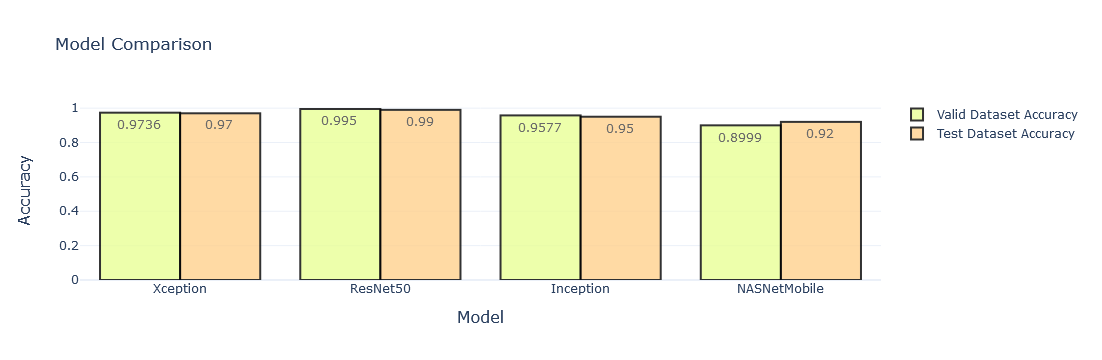

In [166]:
# Model Comparison
models = ['Xception', 'ResNet50', 'Inception', 'NASNetMobile' ]
valid_accuracy = [0.9736, 0.9950, 0.9577, 0.8999]
test_accuracy = [0.97, 0.99, 0.95, 0.92]

fig = go.Figure(data=[
    go.Bar(name='Valid Dataset Accuracy',
          x=models,
          y=valid_accuracy,
          text=valid_accuracy,
          marker_color='#E9FF97'),
    go.Bar(name='Test Dataset Accuracy',
          x=models,
          y=test_accuracy,
          text=test_accuracy,
          marker_color='#FFD18E'),])

fig.update_layout(
    title_text='Model Comparison',
    barmode='group',
    xaxis=dict(
        title='Model',
        titlefont_size=16
    ),
    yaxis=dict(
        title='Accuracy',
        titlefont_size=16
    ),
    template='plotly_white')

fig.update_traces(marker_line_color='black',
                  marker_line_width=2,
                  opacity=0.8)

fig.show()

first image to predict
actual labels Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
predicted label: Potato___Late_blight


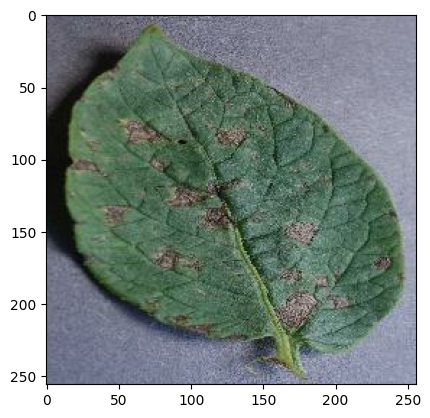

In [178]:
import numpy as np

for n, label in testds.take(1):
    first_image = n[0].numpy().astype('uint8')
    first_label = label[0].numpy()

    print('first image to predict')
    plt.imshow(first_image)
    print('actual labels', class_names[first_label])

    prediction = xception_model.predict(n)
    print("predicted label:",class_names[np.argmax(prediction[0])])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


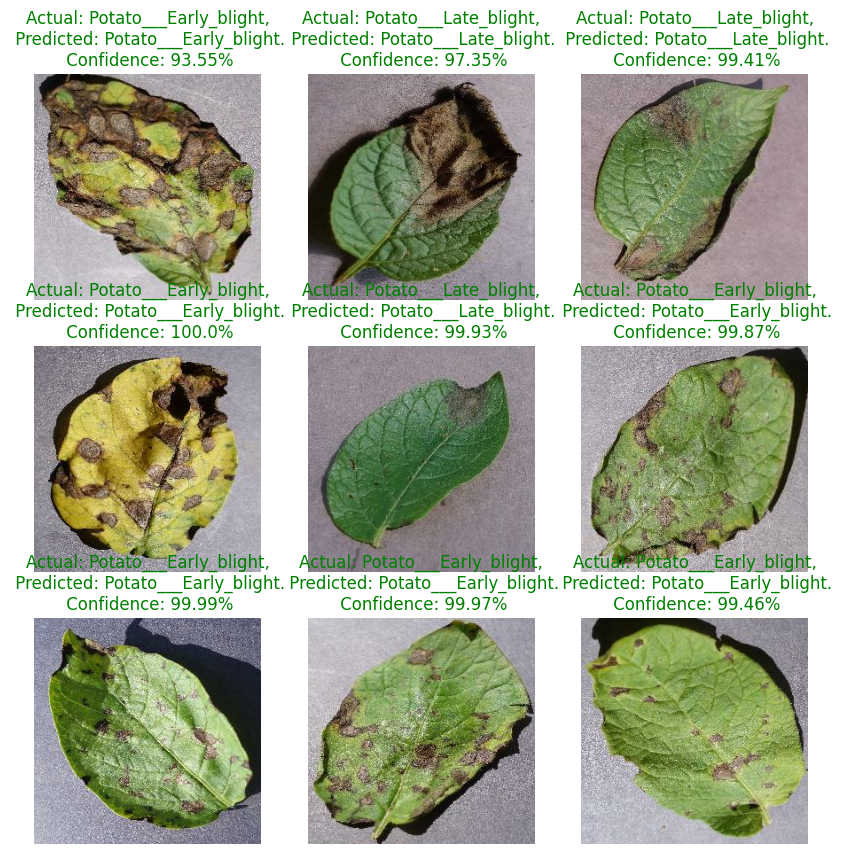

In [181]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


plt.figure(figsize=(10, 10))
for images, labels in testds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(xception_model, images[i].numpy())
        actual_class = class_names[labels[i]]

        if predicted_class == actual_class:
            color = 'green'
        else:
            color = 'red'

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%",color=color)

        plt.axis("off")